In [1]:
import sys
import os

# Step 1: Get current directory 
current_directory = os.getcwd()        # '/home/bear-b/users/jshi008/IvyProjects/FIDLA/train_WaLeF_models'

# Step 2: Get path of parent directory (one level up)
parent_directory = os.path.dirname(current_directory)    # '/home/bear-b/users/jshi008/IvyProjects/FIDLA'

# Step 3: Append parent directory to sys.path
sys.path.append(parent_directory)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *


from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process
from preprocess.graph import graph_topology_5
from models.graph_water_no_transformer_cov import graph_water_no_transformer_cov

2023-09-25 23:46:59.436338: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-25 23:47:00.724257: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

### Parameters

In [4]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

### Preprocess

In [5]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = graph_water_transformer_cov_process(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [6]:
print(train_cov.shape, val_cov.shape, test_cov.shape, 
train_tws_reshape.shape, val_tws_reshape.shape, test_tws_reshape.shape, \
train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

(77069, 96, 12) (9634, 96, 12) (19268, 96, 12) (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) (77069, 96) (9634, 96) (19268, 96)


### Graph topology

In [7]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Model

In [8]:
# ===== model parameters ======
head_size = 96*2
num_heads = 8
ff_dim = 96
num_transformer_blocks = 1
dropout = 0.5
atte_reg = 0
l1_reg = 1e-5
l2_reg = 1e-5
gcn_unit1 = 32
gcn_unit2 = 16
lstm_units = 80
learning_rate = 5e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 500
EPOCHS = 3000
BATCH = 512

In [9]:
input_shape = train_cov.shape[1:]

In [ ]:
model, GCNConv, scores = graph_water_no_transformer_cov(input_shape=input_shape,
                                                         gcn1=gcn_unit1,
                                                         gcn2=gcn_unit2,
                                                         lstm_unit=lstm_units, 
                                                         num_transformer_blocks=num_transformer_blocks,
                                                         head_size=head_size,
                                                         num_heads=num_heads,
                                                         ff_dim=ff_dim, 
                                                         atte_reg=atte_reg, 
                                                         l1_reg=l1_reg, 
                                                         l2_reg=l2_reg, 
                                                         dropout=dropout,
                                                         masked_value=masked_value
                                                        )
# model.summary()

In [ ]:
print(train_cov.shape, train_tws_reshape.shape, train_adj_mat.shape)
print(val_cov.shape, val_tws_reshape.shape, val_adj_mat.shape)
print(test_cov.shape, test_tws_reshape.shape, test_adj_mat.shape)

In [12]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, 
                                                          decay_steps=decay_steps,
                                                          decay_rate=decay_rate)

model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='mse',
              metrics=['mae']
             )


es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint('../saved_models/WaLeF_gtn_p_new.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     custom_objects={'GCNConv': GCNConv},
                     save_best_only=True
                    )


model.fit([train_cov, train_tws_reshape, train_adj_mat], train_ws_y,
          validation_data=([test_cov, test_tws_reshape, test_adj_mat], test_ws_y),
          epochs=EPOCHS,
          batch_size=BATCH,
          verbose=2,
          shuffle=True,
          callbacks=[es, mc]
         )

Epoch 1/3000


KeyboardInterrupt: 

### Performance

In [22]:
saved_model = load_model('../saved_models/WaLeF_gtn_p_new.h5', custom_objects={'GCNConv': GCNConv})

yhat = saved_model.predict([test_cov, test_tws_reshape, test_adj_mat])

inv_yhat = ws_scaler.inverse_transform(yhat)
inv_y = ws_scaler.inverse_transform(test_ws_y)

print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)
print('MAE = {}'.format(float("{:.4f}".format(mae(inv_y, inv_yhat)))))
print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_y, inv_yhat))))))

603/603 [==============================] - 3s 4ms/step
inv_y.shape, inv_yhat.shape (19268, 96) (19268, 96)
MAE = 0.0511
RMSE = 0.0745


In [80]:
print(test_cov.shape, test_tws_reshape.shape)

(19268, 96, 12) (19268, 5, 72)


In [42]:
# wss = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
# inv_yhat_reshape = inv_yhat.reshape((-1, 24, 4))
# inv_y_reshape = inv_y.reshape((-1, 24, 4))

# for i in range(len(wss)):
#     plt.rcParams["figure.figsize"] = (15, 3)
#     error = inv_yhat_reshape - inv_y_reshape
#     plt.plot(error[:, -1, i], linewidth=1)
#     plt.xticks(fontsize=16)
#     plt.yticks(fontsize=16)
#     plt.xlabel('Time steps', fontsize=18)
#     plt.ylabel('Actual Error (ft)', fontsize=18)
#     plt.title('{}'.format(wss[i]), fontsize=18)
#     plt.text(9000, -0.6, 'MAE = {}'.format(float("{:.3f}".format(sum(abs(error[:, -1, i]))/len(error)))), fontsize=12)
#     plt.show()

In [15]:
up_thre = 0.5
low_thre = -0.5

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre) + np.sum(error[:, -1, i] < low_thre))

(19268,)
8
(19268,)
33
(19268,)
7
(19268,)
43


In [16]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre))

(19268,)
6
(19268,)
30
(19268,)
4
(19268,)
41


In [17]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] < low_thre))

(19268,)
2
(19268,)
3
(19268,)
3
(19268,)
2


In [49]:
atte_model = Model(inputs=saved_model.input, 
                   outputs=[saved_model.output, 
                            saved_model.get_layer('attention2').output,
#                             gate_predictor_trained.get_layer('GATConv1').output
                            
                           ]
                        )

In [50]:
ws_pred, (atte_all, atte_all_score) = atte_model.predict([test_cov, test_tws_reshape, test_adj_mat])

603/603 [==============================] - 3s 4ms/step


In [51]:
print(ws_pred.shape, atte_all.shape, atte_all_score.shape)

(19268, 96) (19268, 17, 96) (19268, 8, 17, 17)


In [67]:
demo = 7635

In [68]:
#  0        1         2           3           4
'WS_S4', 'WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26'

#    5          6          7            8            9              10             11
'MEAN_RAIN', 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'GATE_S26_1', 'GATE_S26_2',

#    12           13          14         15          16
'PUMP_S25B', 'PUMP_S26', 'HWS_S25A', 'HWS_S25B', 'HWS_S26',

('PUMP_S25B', 'PUMP_S26', 'HWS_S25A', 'HWS_S25B', 'HWS_S26')

In [69]:
labels = ['MEAN_RAIN', 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'GATE_S26_1', 'GATE_S26_2',
          'PUMP_S25B', 'PUMP_S26', 'HWS_S25A', 'HWS_S25B', 'HWS_S26',
          'WS_S4', 'WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26'
         ]

In [70]:
average_along_axis0 = np.mean(atte_all_score, axis=1)
average_along_axis0.shape

(19268, 17, 17)

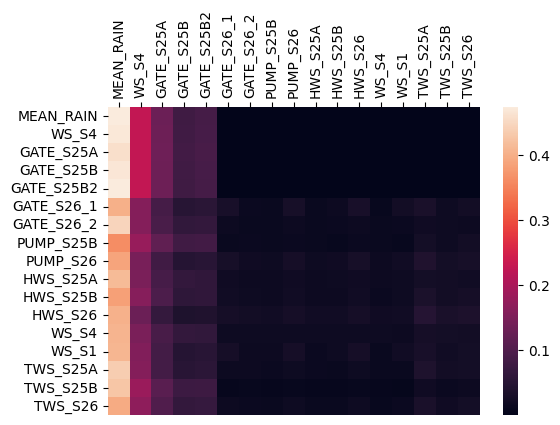

In [71]:
plt.rcParams["figure.figsize"] = (6, 4)
ax = sns.heatmap(average_along_axis0[demo])
ax.xaxis.tick_top()
ax.set_xticklabels(labels, rotation=90)
ax.set_yticklabels(labels, rotation=0)
plt.show()

======== Head 1 ========


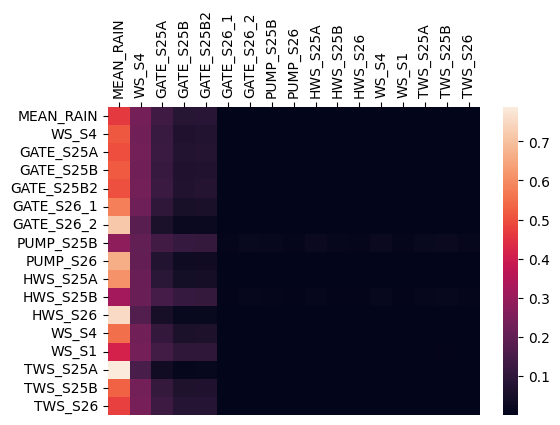

======== Head 2 ========


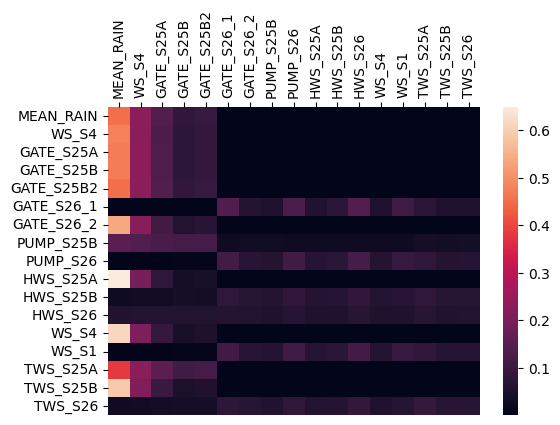

======== Head 3 ========


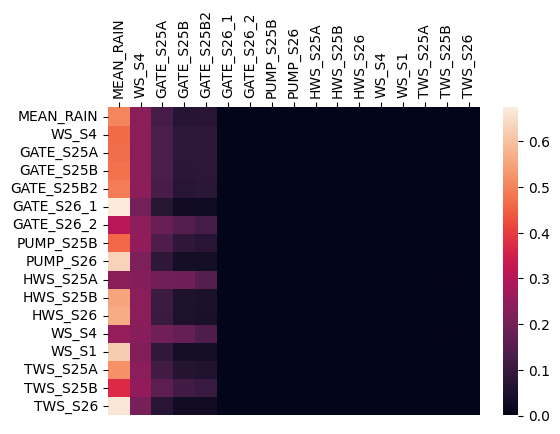

======== Head 4 ========


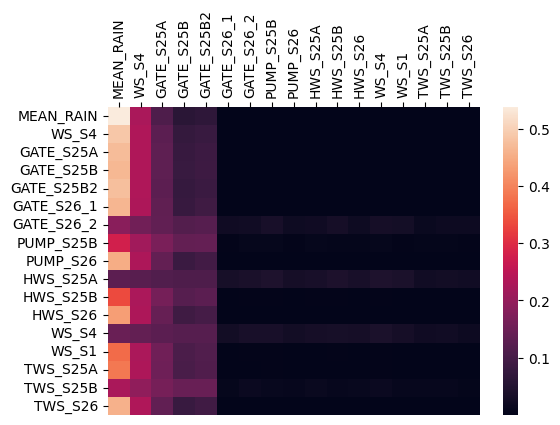

======== Head 5 ========


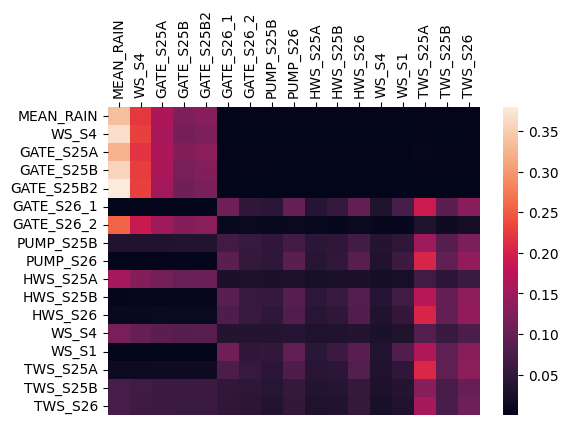

======== Head 6 ========


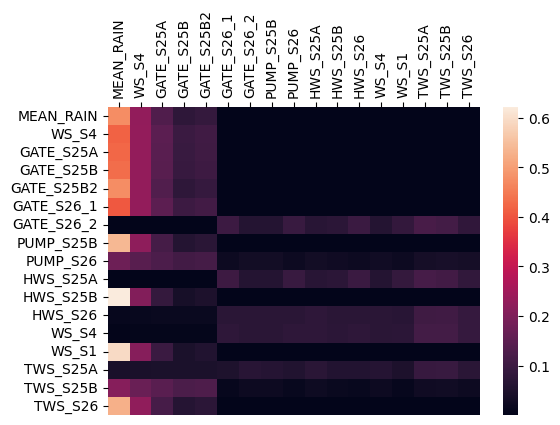

======== Head 7 ========


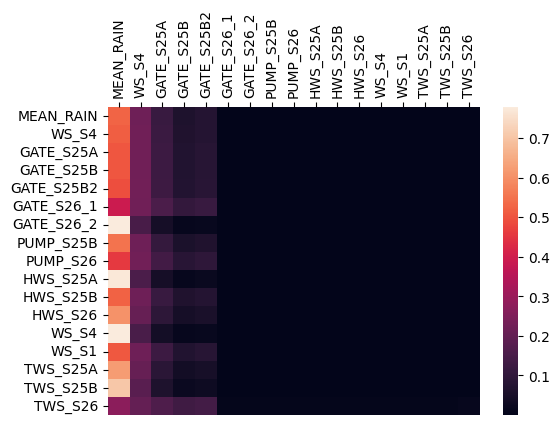

======== Head 8 ========


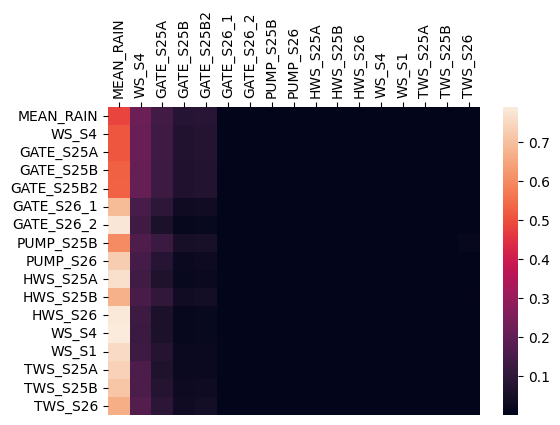

In [72]:
for i in range(8):
    print("======== Head {} ========".format(i+1))
    plt.rcParams["figure.figsize"] = (6, 4)
    ax = sns.heatmap(atte_all_score[demo, i])
    ax.xaxis.tick_top()
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticklabels(labels, rotation=0)
#     plt.xlabel("Variables", fontsize=14)
#     plt.ylabel("Variables", fontsize=14)
    plt.show()

In [73]:
input_data = [test_cov[demo:demo+1, :, :], test_tws_reshape[demo:demo+1, :, :], test_adj_mat[demo:demo+1, :, :]]

In [74]:
feature_matrix = input_data[1]
feature_matrix.shape

(1, 5, 72)

In [75]:
feature_matrix = input_data[1]
feature_matrix = feature_matrix.reshape((72, 5))
# print(feature_matrix.shape)

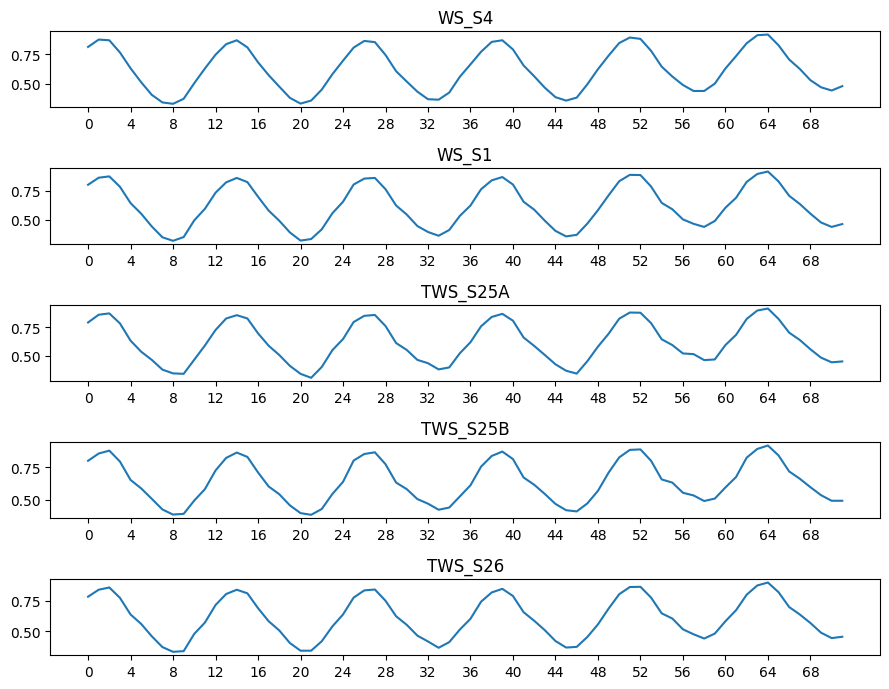

In [78]:
INPUTS = ['WS_S4', 'WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']

plt.rcParams["figure.figsize"] = (9, 7)
fig = plt.figure(tight_layout=True)
gs = matplotlib.gridspec.GridSpec(len(INPUTS), 1)


for i in range(len(INPUTS)):
    ax = fig.add_subplot(gs[i, :])
    ax.plot(feature_matrix[:, i], linewidth=1.5)
    ax.set_title('{}'.format(INPUTS[i]), fontsize=12)
    plt.xticks(np.arange(0, 72, 4))
    
# plt.savefig('INPUTS.png', dpi=300, bbox_inches='tight')
plt.show()

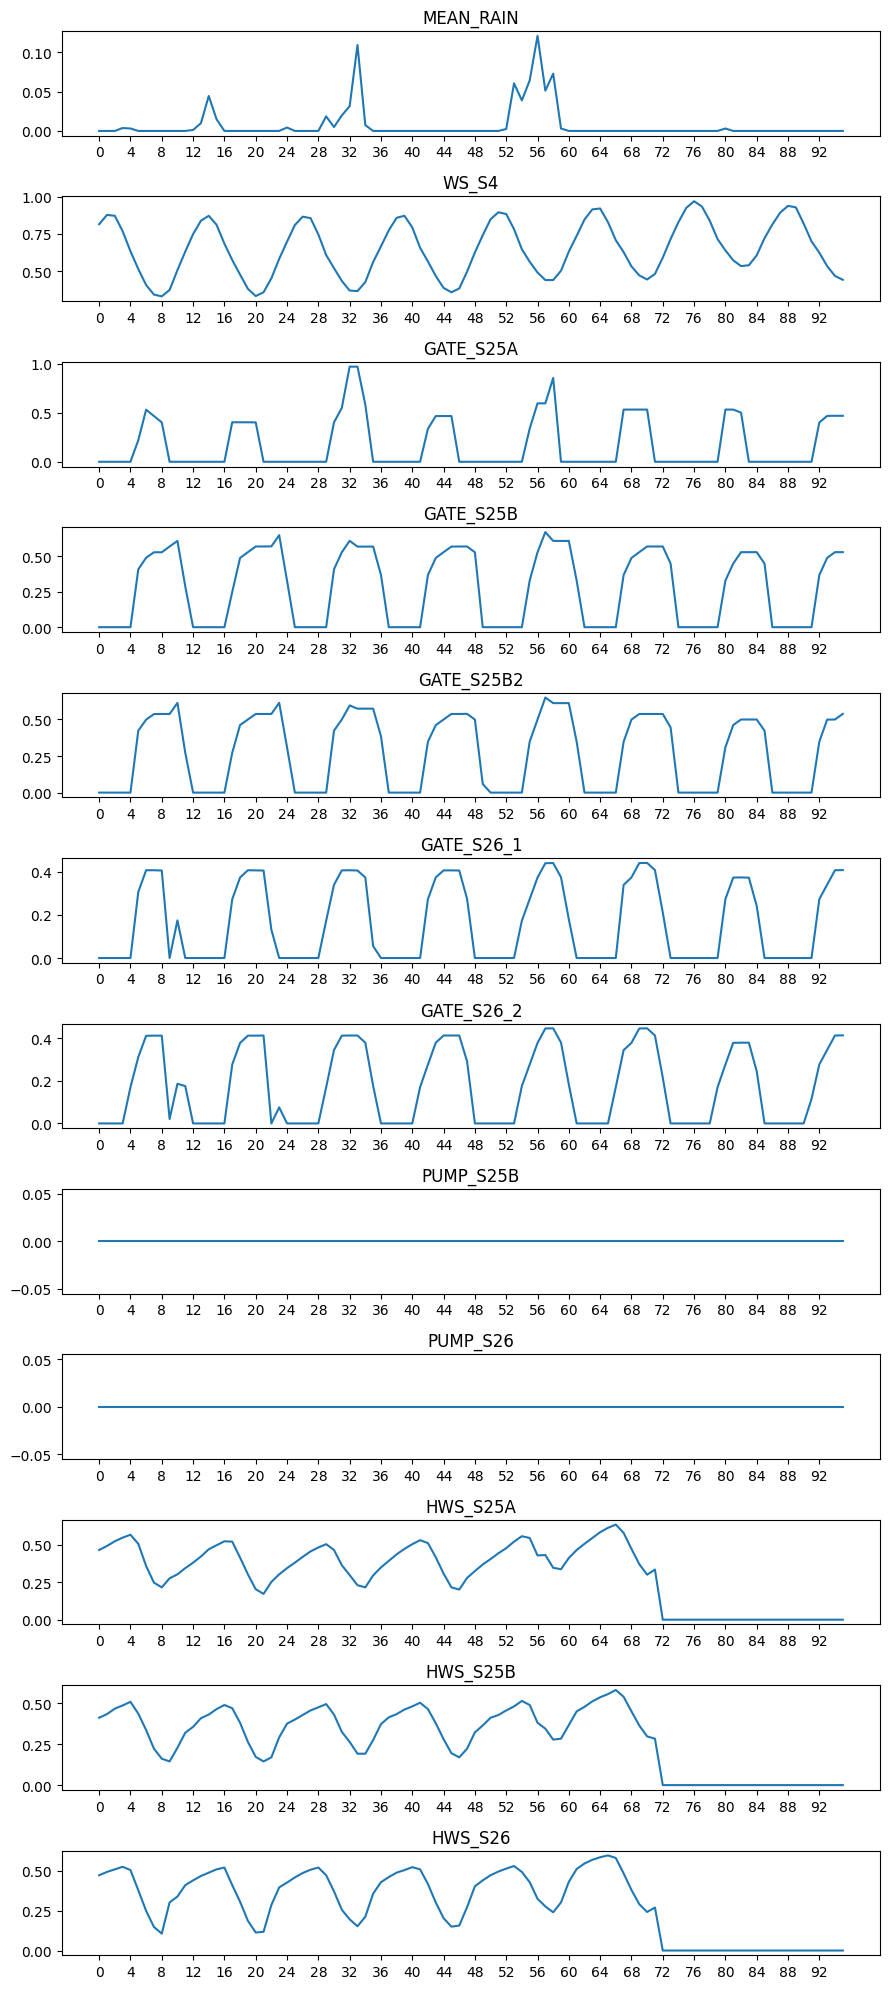

In [79]:
feature_matrix = input_data[0]
feature_matrix = feature_matrix.reshape((96, 12))


INPUTS = ['MEAN_RAIN', 'WS_S4',
          'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'GATE_S26_1', 'GATE_S26_2',
          'PUMP_S25B', 'PUMP_S26',
          'HWS_S25A', 'HWS_S25B', 'HWS_S26']

plt.rcParams["figure.figsize"] = (9, 20)
fig = plt.figure(tight_layout=True)
gs = matplotlib.gridspec.GridSpec(len(INPUTS), 1)


for i in range(len(INPUTS)):
    ax = fig.add_subplot(gs[i, :])
    ax.plot(feature_matrix[:, i], linewidth=1.5)
    ax.set_title('{}'.format(INPUTS[i]), fontsize=12)
    plt.xticks(np.arange(0, 96, 4))
    
# plt.savefig('INPUTS.png', dpi=300, bbox_inches='tight')
plt.show()

In [81]:
dataset = pd.read_csv('../data/Merged-update_hourly.csv', index_col=0)
dataset.fillna(0, inplace=True)
print(dataset.columns)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [82]:
dataset.shape

(96432, 19)

In [104]:
# ==================== convert dataset to supervised mode ====================
data = dataset[['MEAN_RAIN', 'WS_S4',
                'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'GATE_S26_1', 'GATE_S26_2',
                'PUMP_S25B', 'PUMP_S26',
                #'FLOW_S25A', 'FLOW_S25B', 'FLOW_S26', 
                'HWS_S25A', 'HWS_S25B', 'HWS_S26',
                'WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']]

data = data[-19268:]
data.shape

(19268, 16)

In [105]:
import numpy as np
from scipy.stats import pearsonr


In [106]:
import numpy as np
from scipy.stats import pearsonr

# Assuming you have a 2D NumPy array 'data' with shape (365, 16)
# Each row represents a day, and each column represents a different time series

# Transpose the data to make columns represent time series
data_transposed = data.T
num_time_series = data_transposed.shape[0]
data_transposed.shape

(16, 19268)

In [107]:

correlation_matrix = np.zeros((num_time_series, num_time_series))

for i in range(num_time_series):
    for j in range(num_time_series):
#         if i == j:
#             # Skip self-correlation (diagonal elements)
#             continue
        
        ts1 = data_transposed.iloc[i, :]
        ts2 = data_transposed.iloc[j, :]
        
        correlation, _ = pearsonr(ts1, ts2)
        correlation_matrix[i, j] = correlation

# The 'correlation_matrix' now contains the Pearson correlations between each pair of time series


In [108]:
correlation_matrix.shape

(16, 16)

In [109]:
cols = ['MEAN_RAIN', 'WS_S4',
                'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'GATE_S26_1', 'GATE_S26_2',
                'PUMP_S25B', 'PUMP_S26',
                #'FLOW_S25A', 'FLOW_S25B', 'FLOW_S26', 
                'HWS_S25A', 'HWS_S25B', 'HWS_S26',
                'WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']

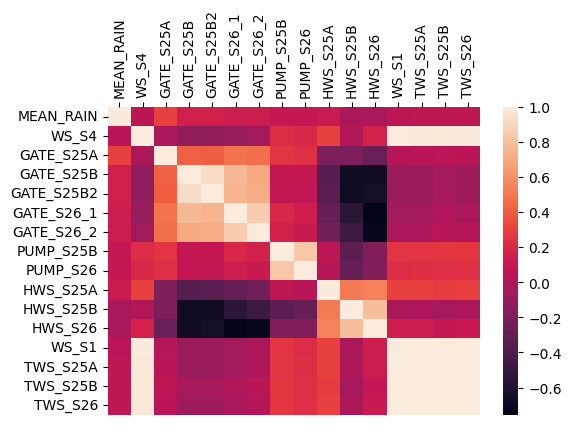

In [110]:
plt.rcParams["figure.figsize"] = (6, 4)
ax = sns.heatmap(correlation_matrix)
ax.xaxis.tick_top()
ax.set_xticklabels(cols, rotation=90)
ax.set_yticklabels(cols, rotation=0)
plt.show()

In [115]:
correlation_matrix = np.concatenate((correlation_matrix[1:2, :-4], correlation_matrix[-4:, :-4]), axis=0)
correlation_matrix.shape

(5, 12)

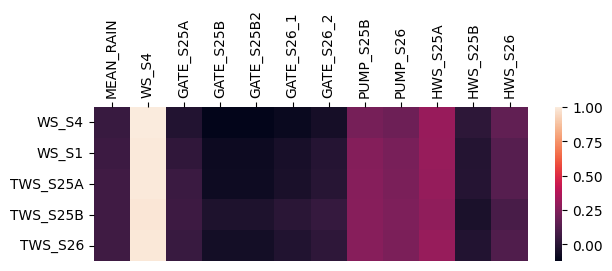

In [118]:
var_labels = ['MEAN_RAIN', 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'GATE_S26_1', 'GATE_S26_2',
              'PUMP_S25B', 'PUMP_S26', 'HWS_S25A', 'HWS_S25B', 'HWS_S26'
             ]

ws_labels = ['WS_S4', 'WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']

plt.rcParams["figure.figsize"] = (7, 2)
ax = sns.heatmap(correlation_matrix)
ax.xaxis.tick_top()
ax.set_xticklabels(var_labels, rotation=90)
ax.set_yticklabels(ws_labels, rotation=0)
plt.show()